## Assignment 5

This assignment is designed to help you understand, implement, and get hold of two important models in Multi-Modal Learning: CLIP and BLIP.

Before starting to code, read the instructions and comments carefully. Make sure you understand the requirements and the expected output.

There are two parts of this assignment.
- Content based image retrieval (CBIR) based on CLIP
- Visual Question Answering (VQA) based on BLIP

## Part 1: Content Based Image Retrieval (CBIR)

Ever found yourself looking for a specific image in a load of photos on your phone?
Imagine you have a system that can retrieve images based on their content. In this assignment, you will implement exactly that.

### Task
1. I have provided a list of images in form of unsplash links. Feel free to explore and add more images.
2. You will have to implement CBIR system that will retrive images based on the query you provide.
3. You have to use CLIP model to extract image and text embeddings. Since CLIP projects both image and text into the same embedding space, similar images and their corresponding text descriptions will be close to each other in the embedding space.
4. You have to use a pretrained CLIP model from HuggingFace. (Because it is not feasible to train CLIP from scratch)
5. You have to use [OpenAI's CLIP](https://huggingface.co/openai/clip-vit-base-patch32) model from HuggingFace. Refer to the page itself and anyother resources you find useful, on how to use it.
6. You will have to take an input query from user, and display the best image matching the query. (You can use cosine similarity to find similarity between the query and the images, then display the image with highest similarity score)

##### Load all the libraries

In [ ]:
!pip install -q pillow torch requests transformers

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import os
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

In [ ]:
IMAGE_URLS = [
    "https://images.unsplash.com/photo-1750126833705-ba98013f16f3",
    "https://images.unsplash.com/photo-1749627995669-4d4dda3a9c1d",
    "https://images.unsplash.com/photo-1744294724362-3f5c404c771a",
    "https://images.unsplash.com/photo-1750075750236-3f8924fc0e35",
]

In [ ]:
os.makedirs("images", exist_ok=True)

for i, url in enumerate(IMAGE_URLS):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image.save(f"images/image_{i+1}.jpg")
    else:
        print(f"Failed to download image from {url}")

In [ ]:
# Load image paths
folder_path="/content/images"
image_files = os.listdir(folder_path)
image_paths = [os.path.join(folder_path, filename) for filename in image_files]

##### Load the CLIP model

In [ ]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

##### Loop through images, convert then to tensors, and store them in a list

In [ ]:
image_tensors = []
for image_path in image_paths:
  image = Image.open(image_path)
  inputs = processor(images=image, return_tensors="pt")
  image_tensors.append(inputs.pixel_values)

##### Get the embeddings for the images and store them in a list
Use the CLIP model linked above, the page also provides details on how to use it. If you have any issues with it, feel free to use anyother resources you find useful.

In [ ]:
image_embeddings = []

for image_tensor in image_tensors:

    with torch.no_grad():
        # Getting the image features
        image_features = model.get_image_features(pixel_values=image_tensor)
        # Normalizing the image features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embeddings.append(image_features)

# Stacking embeddings into one tensor
image_embeddings_tensor = torch.vstack(image_embeddings)


##### Get the query from user

In [ ]:
query = input("Enter which image are you looking for: ")

Enter which image are you looking for: a blue car in the street on the road


##### Get the embeddings for the user query

In [ ]:
text_inputs = processor(text=[query], return_tensors="pt", padding=True)

with torch.no_grad():
    # Getting text features
    text_embeddings = model.get_text_features(**text_inputs)
    # Normalizing the text features
    text_features = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)


##### Find the similarity between the query and all the images

In [ ]:
cosine_similarity = torch.matmul(text_features, image_embeddings_tensor.T)
scores = cosine_similarity.squeeze(0).tolist()

##### Display the image with highest similarity score

Best matching image: /content/images/image_4.jpg


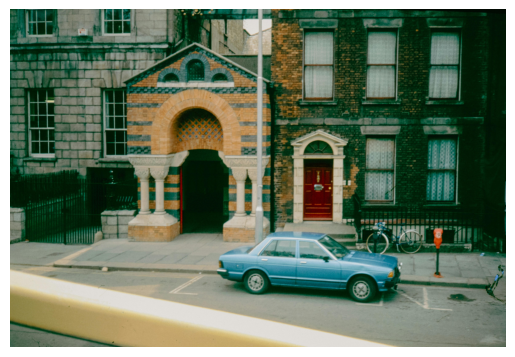

In [ ]:
# Get index of best match

best_image_index = scores.index(max(scores))
best_image_path = image_paths[best_image_index]

print(f"Best matching image: {best_image_path}")
# Display the image
best_image = Image.open(best_image_path)
# Display in notebook cell
plt.imshow(best_image)
plt.axis('off')
plt.show()

Congrats! You have implemented a simple Content Based Image Retrieval (CBIR) system using CLIP model.

Moving on to the next part of the assignment.

## Part 2: Visual Question Answering (VQA)

This part is based on Visual Question Answering (VQA), where you will be given an image and a question about that image, and you will need to provide an answer.

You are provided with a dataset of 10 images, and a json file containing questions and answers for those images.

### Format of JSON file
```json
[
    "what is the blue shape?",
    "rectangle",
    0
]
```
This means that the question is "what is the blue shape?", the answer is "rectangle", and the image index is 0.
Images are named from 0 to 9, so the image for index 0 is `0.png`.

### Task
1. Load the JSON file and parse the questions and answers.
2. Just for understanding, print a few questions and their corresponding answers, also display the corresponding images. (You may do it for 1 or 2 questions)
3. Implement a function that takes an image and a question, and returns the answer.
4. Run the function on all questions and store the answers in a file. (You can store it in a new JSON or CSV file) (May use pandas for this)
5. Now since you have the answers, you can also evaluate your model. For this, you can compare your answers with the ground truth answers provided in the JSON file. (refer to note below)

Note: But it is not that easy to compare directly, as the answers may not match exactly due to variations in phrasing ("2" and "two", "blue" and "The color is blue". Phrases like this don't match, but are correct). So you should check your answers manually and see if they are correct or not. Do it for first 30 answers, and calculate the accuracy.
There are certain ways to automate this, but they will make this assignment too complicated, so we will not do that here.

### Additional Points
- Refer to BLIP model that was taught in last class. It can be used to answer questions based on images.
- You will have to use pre-trained BLIP model for this task. (Because training it from scratch is not feasible in this assignment)
- You have to use [Salesforce BLIP model](https://huggingface.co/Salesforce/blip-vqa-base) for this task. Refer to the Usage section of page for details on how to use it. If you feel stuck, you can refer to blogs available online, or use AI tools to get yourself familiar with the model.

1. Load libraries, and the JSON file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers pillow pandas

In [ ]:
# Loading libraries
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import json
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load the filtered questions from the JSON file
with open("/content/drive/Othercomputers/My Laptop/projects/FramestoFables/Assignment 5/Assignment 5/filtered_questions.json", "r") as f:
    data = json.load(f)

In [ ]:
# Load the BLIP model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

2. Display a few questions and answers along with images.

Question 3: does the image contain a rectangle?
Answer 3: yes


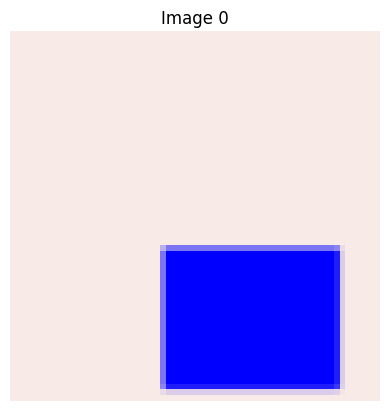

Question 4: is there a triangle in the image?
Answer 4: no


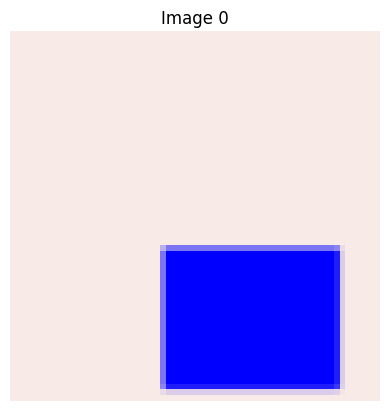

In [ ]:
# Display next 2 examples
for i in range(2,4):
    question, answer, image_idx = data[i]

    print(f"Question {i+1}: {question}")
    print(f"Answer {i+1}: {answer}")

    image_path = f"/content/drive/Othercomputers/My Laptop/projects/FramestoFables/Assignment 5/Assignment 5/images_updated/{image_idx}.png"
    image = Image.open(image_path)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {image_idx}")
    plt.show()

3. Implement the function to answer questions based on images.

In [ ]:
def vqa(question, image):
    # Extract the image path from the image object
    raw_image = Image.open(image_path).convert("RGB")
    # Preprocess the image and question
    inputs = processor(raw_image, question, return_tensors="pt")
    # Generate the answer
    out = model.generate(**inputs)
    answer = processor.decode(out[0], skip_special_tokens=True)
    return answer

4. Run the function on all questions and store the answers in a file.

In [ ]:
results = []
# Iterating through the data and calling the VQA function
for item in data:
    question, answer, image_idx = item
    image_path = f"/content/drive/Othercomputers/My Laptop/projects/FramestoFables/Assignment 5/Assignment 5/images_updated/{image_idx}.png"
    pred = vqa(image_path, question)
    # Storing the results
    results.append({
        "image_index": image_idx,
        "question": question,
        "ground_truth": answer,
        "predicted_answer": pred
    })

df = pd.DataFrame(results)

5. Evaluate the model by comparing answers with ground truth.
Do the comparison manually for the first 30 answers and print the accuracy.

In [ ]:
df.head(30)

,image_index,question,ground_truth,predicted_answer
0,0,what is the blue shape?,rectangle,no
1,0,what color is the shape?,blue,no
2,0,does the image contain a rectangle?,yes,no
3,0,is there a triangle in the image?,no,no
4,0,is there a black shape?,no,no
5,0,does the image not contain a gray shape?,yes,no
6,0,is there a red shape in the image?,no,no
7,0,does the image not contain a red shape?,yes,no
8,0,is there not a blue shape?,no,no
9,0,is there not a blue shape in the image?,no,no


In [ ]:
total=30
correct=0
for i in range(30):
  if df.loc[i, 'ground_truth'] == df.loc[i, 'predicted_answer']:
    correct+=1
accuracy = (correct / total) * 100
print(f"Accuracy: {accuracy}%")

Accuracy: 33.33333333333333%


Bonus: This images were too simple. But guess what? Salesforce has pretrained it's model on wide variety of images, so you can use it on any image of your choice.

Try to load any real world image of any natural scene, or anything you like, and ask questions about it. You will be surprised by the results.

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

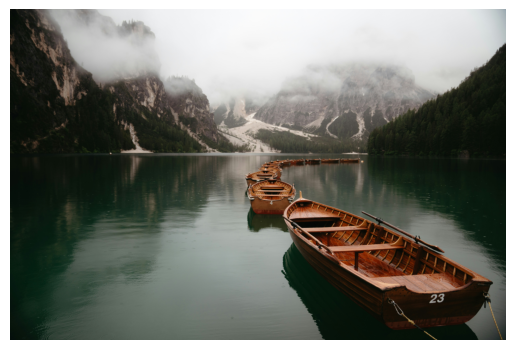

In [ ]:
url = "https://images.unsplash.com/photo-1750126833705-ba98013f16f3"  # boats in mountain lake
response = requests.get(url)

# Open the image from the response content
image = Image.open(BytesIO(response.content)).convert("RGB")

# Display image
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# Visual Question Answering examples using BLIP for the above image
questions = [
    "Are there boats in the image",
    "Are there mountains in the image?",
    "What color is the lake?",
    "Is there snow?",
    "Is this image taken during daytime?",
    "Is there fog in the image?",
    "Are there any people in the image?",
]

for q in questions:
    answer = vqa(q, image)
    print(f"Question: {q}")
    print(f"Answer: {answer}\n")


Question: Are there boats in the image
Answer: no

Question: Are there mountains in the image?
Answer: no

Question: What color is the lake?
Answer: blue

Question: Is there snow?
Answer: no

Question: Is this image taken during daytime?
Answer: yes

Question: Is there fog in the image?
Answer: yes

Question: Are there any people in the image?
Answer: no



The End 🫡.

If you have any questions, feel free to use following in the given order:
- Google it!!
- ChatGPT
- Ask on the group